In [164]:
import requests
import regex as re
import json
import time
import random
import networkx as nx
import pandas as pd

In [165]:
def open_file(filepath:str='cache.json')->dict:
    '''Opens a file'''
    cache_file = open(filepath, 'r')
    cache_contents = cache_file.read()
    artist_data = json.loads(cache_contents)
    cache_file.close()
    return artist_data

In [166]:
def load_full_network(playlist_link:str,random_link:str,cache_file:str)->nx.Graph:
    playlist_network = open_file(playlist_link)
    random_network = open_file(random_link)
    cache = open_file(cache_file)
    # combine!!

    # playlist network doesn't have name key, my bad
    for artist in playlist_network.keys():
        playlist_network[artist]['name']=artist

    g = nx.Graph()
    for artist in playlist_network.keys():
        g.add_node(artist)
        colab = playlist_network[artist]['collaborators'].keys()
        for y in colab:
            if artist !=y:
                if y not in g.nodes:
                    g.add_node(y)
                g.add_edge(artist,y)

    for n in g.nodes():
        g.nodes[n]['source'] = 'playlist'
        if n in playlist_network.keys():
            for key in playlist_network[n].keys():
                g.nodes[n][key]= playlist_network[n][key]
        else:
            for key in cache[n].keys():
                g.nodes[n][key]=cache[n][key]
            g.nodes[n]['in_playlist']=False
            g.nodes[n]['name']=n


    for artist in random_network.keys():
        if artist not in g.nodes:
            g.add_node(artist)
            g.nodes[artist]['source']='random'
        colab = random_network[artist]['collaborators'].keys()
        for y in colab:
            if artist !=y:
                if y not in g.nodes:
                    g.add_node(y)
                g.add_edge(artist,y)
                g.nodes[y]['source']='random'

    for n in g.nodes():
        if n in random_network.keys():
            for key in random_network[n].keys():
                g.nodes[n][key]= random_network[n][key]
            g.nodes[n]['in_playlist']=False
            g.nodes[n]['name']=n
            if n not in playlist_network.keys():
                for key in cache[n].keys():
                    g.nodes[n][key]=cache[n][key]
            g.nodes[n]['source']='random'
    return g

In [167]:
# loading complete networks
week1_g = load_full_network('10_26_playlist_layer2.json','10_26_random_2layer.json','cache.json')
week2_g = load_full_network('11_01_playlist_layer2.json','10_26_random_2layer.json','cache.json')
week3_g = load_full_network('11_08_playlist_layer2.json','10_26_random_2layer.json','cache.json')

Now I want to gather the info about the different networks and see how they change.

In [168]:
# make dataframe with networks attributes
week1_df =pd.DataFrame.from_dict(dict(week1_g.nodes(data=True)), orient='index')
week2_df =pd.DataFrame.from_dict(dict(week2_g.nodes(data=True)), orient='index')
week3_df =pd.DataFrame.from_dict(dict(week3_g.nodes(data=True)), orient='index')
# print the columns
print(week1_df.columns)

Index(['source', 'genres', 'img_info', 'popularity', 'followers',
       'collaborators', 'in_playlist', 'link', 'name', 'api_link'],
      dtype='object')


In [20]:
# making an easy way to iterate
graphs = {
    'week1': {'graph':week1_g, 'df':week1_df},
          'week2': {'graph':week2_g, 'df':week2_df},
          'week3': {'graph':week3_g, 'df':week3_df},}

In [169]:
week3_df['name']=week3_df.index
week2_df['name']=week2_df.index
week1_df['name']=week1_df.index

In [24]:
for week in graphs.keys():
    print(week)
    # set graph & df
    g, df = graphs[week]['graph'], graphs[week]['df']
    # get pagerank
    pr = nx.pagerank(g)
    df['pagerank']=df['name'].apply(lambda x: pr[x])
    # get closeness centrality
    cc = nx.closeness_centrality(g)
    df['closeness_cent']=df['name'].apply(lambda x: cc[x])
    # clustering
    clust = nx.clustering(g)
    df['clustering']=df['name'].apply(lambda x: clust[x])
    # degree centrality
    deg_cent = nx.degree_centrality(g)
    df['deg_cent']=df['name'].apply(lambda x: deg_cent[x])
    # betweenness centrality
    btwn_centr = nx.betweenness_centrality(g)
    df['btwn_centr']=df['name'].apply(lambda x: btwn_centr[x])
    # degree
    deg = nx.degree(g)
    df['degree']=df['name'].apply(lambda x: deg[x])

week1
week2
week3


In [ ]:
playlist_nodes = [x for x in week1_g.nodes if week1_g.nodes[x]['source']=='playlist'] #if week1_g.nodes[x]['source']=='playlist'
random_nodes = [x for x in week1_g.nodes if week1_g.nodes[x]['source']=='random']

In [27]:
# set weeks in col
graphs['week1']['df']['week']=1
graphs['week2']['df']['week']=2
graphs['week3']['df']['week']=3
# combine
mega = pd.concat([graphs['week1']['df'],graphs['week2']['df'],graphs['week3']['df']],axis=0)

In [32]:
playlist_week =mega.groupby(['in_playlist','week'])[['pagerank','closeness_cent','clustering','deg_cent','degree','btwn_centr']].mean().reset_index()
playlist_week

,in_playlist,week,pagerank,closeness_cent,clustering,deg_cent,degree,btwn_centr
0,False,1,0.000047,0.182954,0.072061,0.000168,6.066004,0.000274
1,False,2,0.000047,0.183071,0.071849,0.000169,6.093530,0.000277
2,False,3,0.000047,0.183057,0.072211,0.000170,6.107378,0.000278
3,True,1,0.000116,0.223681,0.138634,0.000469,16.964789,0.002109
4,True,2,0.000114,0.222563,0.140451,0.000466,16.798561,0.002047
5,True,3,0.000113,0.222744,0.143961,0.000461,16.600000,0.002024


In [49]:
mega[mega.clustering==1]

,source,genres,img_info,popularity,followers,collaborators,in_playlist,link,name,api_link,pagerank,closeness_cent,clustering,deg_cent,btwn_centr,degree,week
JOVINCII,playlist,[],[{'url': 'https://i.scdn.co/image/ab6761610000...,7.0,26.0,"{'Darking On': {'count': 1, 'uri': 'spotify:ar...",True,https://api.spotify.com/v1/artists/37TgkjlxzBB...,JOVINCII,NaN,0.000016,0.206650,1.0,0.000055,0.0,2,1
Yoko Gold,random,[],[{'url': 'https://i.scdn.co/image/ab6761610000...,63.0,11270.0,"{'Yoko Gold': {'count': 6, 'uri': 'spotify:art...",False,NaN,Yoko Gold,NaN,0.000015,0.182122,1.0,0.000055,0.0,2,1
Chris Sonic,playlist,[],[{'url': 'https://i.scdn.co/image/ab6761610000...,0.0,82.0,"{'Chris Sonic': {'count': 15, 'uri': 'spotify:...",False,NaN,Chris Sonic,NaN,0.000016,0.206673,1.0,0.000055,0.0,2,1
Arya mewada,playlist,[],[{'url': 'https://i.scdn.co/image/ab6761610000...,0.0,87.0,"{'Arya mewada': {'count': 9, 'uri': 'spotify:a...",False,NaN,Arya mewada,NaN,0.000017,0.206673,1.0,0.000055,0.0,2,1
Arya Mewada,playlist,[],[{'url': 'https://i.scdn.co/image/ab67616d0000...,0.0,0.0,"{'Mixo': {'count': 1, 'uri': 'spotify:artist:5...",False,NaN,Arya Mewada,NaN,0.000017,0.206673,1.0,0.000055,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pirisca Grecco,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pirisca Grecco,NaN,0.000021,0.204442,1.0,0.000056,0.0,2,3
LFERDA,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LFERDA,NaN,0.000018,0.172969,1.0,0.000056,0.0,2,3
MC JO,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MC JO,NaN,0.000019,0.160640,1.0,0.000056,0.0,2,3
NORDO,random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORDO,NaN,0.000018,0.205328,1.0,0.000056,0.0,2,3


In [62]:
# top pagerank
print('Top Pagerank',mega.sort_values('pagerank',ascending=False).head(9)['name'].unique())
# top degree
print('Highest degree',mega.sort_values('degree',ascending=False).head(9)['name'].unique())
# highest closeness cent
print('Highest closeness cent',mega.sort_values('closeness_cent',ascending=False).head(9)['name'].unique())
# highest closeness cent
print('Highest btwn cent',mega.sort_values('btwn_centr',ascending=False).head(9)['name'].unique())
# clustering of 1
print('There are these many nodes with clustering of 1: ',len(mega[mega.clustering==1]['name'].unique()))

Top Pagerank ['Various Artists' 'Gioachino Rossini' 'Christoph Willibald Gluck']
Highest degree ['Various Artists' 'Christoph Willibald Gluck' 'Gioachino Rossini']
Highest closeness cent ['Various Artists' "Orchestre National de l'O.R.T.F." 'Maurice André']
Highest btwn cent ['Various Artists' "Orchestre National de l'O.R.T.F." 'Maurice André']
There are these many nodes with clustering of 1:  2021


The most important nodes are 'various artists', 'Giochino Rossini', and 'Christiph Willibald Gluck' via PageRank. They are also the artists with the highest degree.

In [60]:
# FOR ARTISTS ONLY IN PLAYLIST
# top pagerank
print('Top Pagerank',mega[mega.in_playlist==True].sort_values('pagerank',ascending=False).head(9)['name'].unique())
# top degree
print('Highest degree',mega[mega.in_playlist==True].sort_values('degree',ascending=False).head(9)['name'].unique())
# highest closeness cent
print('Highest closeness cent',mega[mega.in_playlist==True].sort_values('closeness_cent',ascending=False).head(9)['name'].unique())
# highest closeness cent
print('Highest btwn cent',mega[mega.in_playlist==True].sort_values('btwn_centr',ascending=False).head(9)['name'].unique())
# clustering of 1
print('There are these many nodes with clustering of 1: ',mega[(mega.in_playlist==True) & (mega.clustering==1)]['name'].unique())

Top Pagerank ['Jetason' 'mavzy grx' 'Egzod']
Highest degree ['Jetason' 'mavzy grx' 'Egzod']
Highest closeness cent ['Bruno Mars' 'Waxel' 'Playboi Carti']
Highest btwn cent ['Egzod' 'Gulmee' 'Jetason' 'Hanumankind']
There are these many nodes with clustering of 1:  ['JOVINCII' 'Rave The Storm' 'Arnie Way' 'HH韩湘子' 'Hasan Aydın'
 'Sanjesh Meshram']


<Axes: xlabel='week', ylabel='degree'>

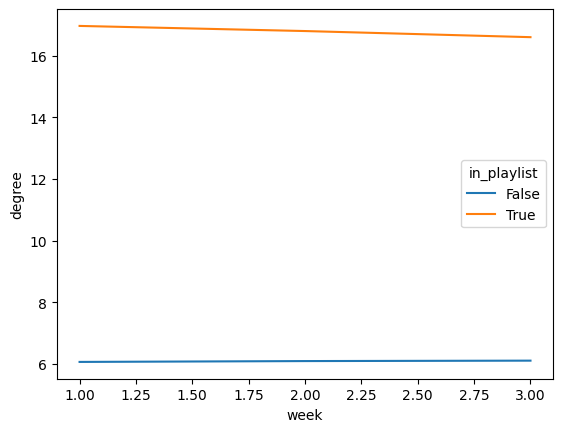

In [38]:
import seaborn as sns
#sns.lineplot(playlist_week,x='week',y='closeness_cent',hue='in_playlist')
#sns.lineplot(playlist_week,x='week',y='clustering',hue='in_playlist')
sns.lineplot(playlist_week,x='week',y='degree',hue='in_playlist')

In [29]:
mega.groupby(['in_playlist','source','week'])[['pagerank','closeness_cent','clustering','deg_cent','degree','btwn_centr']].mean()

pagerank  closeness_cent  clustering  deg_cent  \
in_playlist source   week                                                   
False       playlist 1     0.000022        0.175267    0.053805  0.000067   
                     2     0.000022        0.175277    0.052675  0.000067   
                     3     0.000022        0.175233    0.053135  0.000067   
            random   1     0.000099        0.198879    0.109884  0.000377   
                     2     0.000098        0.198846    0.110660  0.000376   
                     3     0.000099        0.198842    0.110696  0.000377   
True        playlist 1     0.000103        0.223608    0.154641  0.000410   
                     2     0.000102        0.222161    0.159711  0.000406   
                     3     0.000102        0.221795    0.162075  0.000408   
            random   1     0.000153        0.223906    0.089698  0.000648   
                     2     0.000148        0.223673    0.087356  0.000631   
                     3     0.000144        0.225564    0.090152  0.000618   

                              degree  btwn_centr  
in_playlist source   week                         
False       playlist 1      2.406095    0.000050  
                     2      2.401583    0.000050  
                     3      2.402312    0.000050  
            random   1     13.648421    0.000740  
                     2     13.566504    0.000735  
                     3     13.582117    0.000738  
True        playlist 1     14.850467    0.001935  
                     2     14.637255    0.001866  
                     3     14.693069    0.001870  
            random   1     23.428571    0.002643  
                     2     22.756757    0.002545  
                     3     22.264706    0.002480

Cannot get ASP because graph is unconnected, let's get ASP of largest connected component.

In [65]:
nx.number_connected_components(graphs['week1']['graph']),nx.number_connected_components(graphs['week2']['graph']),nx.number_connected_components(graphs['week3']['graph'])

(29, 29, 29)

In [69]:
sorted(nx.connected_components(graphs['week1']['graph']), key=len, reverse=True)[0]

{'Kishin Nagai',
 'iann dior',
 'F1 El Control',
 'Fritz Zaun',
 'Rosita Frisani',
 'Filip Melvan',
 'Navambar',
 'Irma Lepuri',
 'Gundula Janowitz',
 'Ben Fero',
 'steven shaeffer',
 'Reinier Zonneveld',
 'Lexton',
 'DVS 7.0',
 'Mr. Oizo',
 'Kwesi',
 'Roska',
 'Adolf Jensen',
 'Livingston Crain',
 'Kiran Varghese',
 'Hardbrant',
 'Schola Gregoriana Gregoriani Urbis Cantores',
 'EricBeatz',
 'Kore',
 'Munich Symphony Orchestra',
 'John Keys',
 'NOISETIME',
 'Diplo',
 'REEEF',
 'TK',
 'Hirak Jyoti Sarma',
 'Dillom',
 'Bandlez',
 'Indo',
 'Luthfi Syach',
 'Evgeny Samoyloff',
 'Rina Rapa',
 'Michael Kleiser',
 'Venesti',
 'NADA',
 'Wreckno',
 'R3YMON',
 'Army Of The Pharaohs',
 'Moav Covers',
 'VALORANT',
 'Bernadette Lucarini',
 'Carlo Grante',
 'Lennart Wastesson',
 'Leonardo',
 'DODO.027',
 'Shiny Das',
 'sunsetto',
 'Opella Musica',
 'Rachit',
 'Wallace',
 'Pati Taii',
 'Pedro Capó',
 'Grupo Aperte o Play',
 'Omen',
 'Akarena',
 'Michael Spyres',
 'KOU',
 'Crystal Waters',
 'Marcus Bo

In [170]:
cache = open_file('cache.json')
df = week3_df.copy()

In [125]:
for x in list(df['name']):
    collab = df[df.name==x]['collaborators'].isna().item()
    if collab:
        # update collaborators
        if x in cache.keys():
            print(x)
            df.loc[df.name ==x,'collaborators']=cache[x]
        break


IU


In [174]:
def update_null_collaborators(row:pd.Series):
    collab_na = row.isna()['collaborators']
    name = row['name']
    if collab_na:
        if name in cache.keys() and ('collaborators' in cache[name].keys()):
            output = cache[name]['collaborators']
        else:
            output = row['collaborators']
    else:
        output = row['collaborators']
    return output

In [175]:
df['collaborators']=df.apply(lambda x: update_null_collaborators(x),axis=1)

In [176]:
df[df.name=='Repiet']['collaborators']

Repiet    NaN
Name: collaborators, dtype: object

In [148]:
tttt = df[df.name =='Repiet'].copy()
tttt['test']=tttt.apply(lambda x: update_null_collaborators(x),axis=1)
tttt

Repiet


,source,genres,img_info,popularity,followers,collaborators,in_playlist,name,link,api_link,pagerank,closeness_cent,clustering,deg_cent,btwn_centr,degree,week,test
Repiet,random,[future bounce],[{'url': 'https://i.scdn.co/image/ab6761610000...,61.0,18606.0,NaN,False,Repiet,NaN,NaN,0.000022,0.184108,0.0,0.000083,0.000026,3,3,"{'genres': ['future bounce'], 'img_info': [{'u..."


In [108]:
graphs['week3']['df'].sample()

,source,genres,img_info,popularity,followers,collaborators,in_playlist,name,link,api_link,pagerank,closeness_cent,clustering,deg_cent,btwn_centr,degree,week
Repiet,random,[future bounce],[{'url': 'https://i.scdn.co/image/ab6761610000...,61.0,18606.0,NaN,False,Repiet,NaN,NaN,0.000022,0.184108,0.0,0.000083,0.000026,3,3


In [177]:
# save to csv for my peers
graphs['week1']['df'].to_csv('week1.csv')
graphs['week2']['df'].to_csv('week2.csv')
graphs['week3']['df'].to_csv('week3.csv')
df.to_csv('week3.csv')